In [14]:
import torch
import numpy as np
import os
import pandas as pd

import cv2

In [47]:
CLASS_NAME_TO_ID = {'Bus': 0, 'Truck': 1}
CLASS_ID_TO_NAME = {0: 'Bus', 1: 'Truck'}

In [65]:
class Detection_dataset():
    def __init__(self, data_dir, phase, transformer=None):
        self.data_dir = data_dir
        self.phase = phase
        self.data_df = pd.read_csv(os.path.join(data_dir, 'df.csv'))
        self.image_files = [fn for fn in os.listdir(os.path.join(self.data_dir, phase)) if fn.endswith("jpg")]
        self.transformer = transformer

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        # input : image
        # tagget : label (box, class_id)
        # get_image -> filiname(imageId) -> get_label
        filename, image = self.get_image(index)
        bboxes, class_ids = self.get_label(filename)
        img_H, img_W, _ = image.shape
        if self.transformer:
            # image shape: (H, W, C)
            # tensor hspa: (C, H, W)
            image = self.transformer(image)
            _, img_H, img_W = image.shape
        
        bboxes[:, [0,2]] *= img_W
        bboxes[:, [1,3]] *= img_H
        # bboxes = [[xmin, ymin, xmax, ymax]] -> [0,2]:xmin, xmax / [1,3]: ymin, ymax
        
        target = {}
        target["boxes"] = torch.Tensor(bboxes).float()
        target["labels"] = torch.Tensor(class_ids).long()
            
        return image, target, filename
    
    def get_image(self, index):
        filename = self.image_files[index]
        image_path = os.path.join(self.data_dir, self.phase, filename)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return filename, image
    
    def get_label(self, filename):
        image_id = filename.split('.')[0]
        meta_data = self.data_df[self.data_df['ImageID'] == image_id]
        cate_names = meta_data["LabelName"].values
        class_ids = np.array([CLASS_NAME_TO_ID[cate_name] for cate_name in cate_names])
        bboxes = meta_data[["XMin", "XMax", "YMin", "YMax"]].values
        bboxes[:, [1,2]] = bboxes[:, [2,1]]
        return bboxes, class_ids

In [88]:
data_dir = "./Detection/"
dataset = Detection_dataset(data_dir=data_dir, phase="train", transformer=None)

In [40]:
len(dataset)

13703

In [89]:
dataset[0]

(array([[[3, 3, 3],
         [3, 3, 3],
         [4, 4, 4],
         ...,
         [8, 8, 6],
         [4, 4, 2],
         [4, 4, 2]],
 
        [[4, 4, 4],
         [4, 4, 4],
         [4, 4, 4],
         ...,
         [9, 9, 7],
         [4, 4, 2],
         [4, 4, 2]],
 
        [[4, 4, 4],
         [4, 4, 4],
         [4, 4, 4],
         ...,
         [9, 9, 7],
         [4, 4, 2],
         [4, 4, 2]],
 
        ...,
 
        [[3, 3, 3],
         [3, 3, 3],
         [3, 3, 3],
         ...,
         [4, 4, 4],
         [4, 4, 4],
         [4, 4, 4]],
 
        [[3, 3, 3],
         [3, 3, 3],
         [3, 3, 3],
         ...,
         [4, 4, 4],
         [4, 4, 4],
         [4, 4, 4]],
 
        [[3, 3, 3],
         [3, 3, 3],
         [2, 2, 2],
         ...,
         [4, 4, 4],
         [5, 5, 5],
         [5, 5, 5]]], dtype=uint8),
 {'boxes': tensor([[ 66.4000, 105.4401, 208.1600, 153.4401]]),
  'labels': tensor([1])},
 '63908fdf1f3d13fe.jpg')

In [74]:
index = 0
image, target, filename = dataset[index]

image.shape

(192, 256, 3)

In [75]:
target

{'boxes': tensor([[ 66.4000, 105.4401, 208.1600, 153.4401]]),
 'labels': tensor([1])}

In [76]:
dataset.data_df.iloc[0]

ImageID        0000599864fd15b3
Source                   xclick
LabelName                   Bus
Confidence                    1
XMin                    0.34375
XMax                    0.90875
YMin                   0.156162
YMax                   0.650047
IsOccluded                    1
IsTruncated                   0
IsGroupOf                     0
IsDepiction                   0
IsInside                      0
XClick1X               0.421875
XClick2X                0.34375
XClick3X                  0.795
XClick4X                0.90875
XClick1Y               0.156162
XClick2Y                 0.5127
XClick3Y               0.650047
XClick4Y               0.457197
Name: 0, dtype: object

In [57]:
import matplotlib.pyplot as plt

In [69]:
BOX_COLOR = {'Bus':(200, 0, 0), 'Truck':(0, 0, 200)}
TEXT_COLOR = (255, 255, 255)

def visualize_bbox(image, bbox, class_name, color=BOX_COLOR, thickness=2):
    x_center, y_center, w, h = bbox
    x_min = int(x_center - w/2)
    y_min = int(y_center - h/2)
    x_max = int(x_center + w/2)
    y_max = int(y_center + h/2)
    
    cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color=color[class_name], thickness=thickness)
    
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(image, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), color[class_name], -1)
    cv2.putText(
        image,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35, 
        color=TEXT_COLOR, 
        lineType=cv2.LINE_AA,
    )
    return image


def visualize(image, bboxes, category_ids):
    img = image.copy()
    for bbox, category_id in zip(bboxes, category_ids):
        class_name = CLASS_ID_TO_NAME[category_id]
        img = visualize_bbox(img, bbox, class_name)
    return img

In [70]:
target

{'boxes': tensor([[ 66.4000, 156.1200, 140.5867, 153.4401]]),
 'labels': tensor([1])}

boxes: [[ 66.4     105.44006 208.16    153.44006]]
bboxes: [[137.28    129.44006 141.76001  48.     ]]


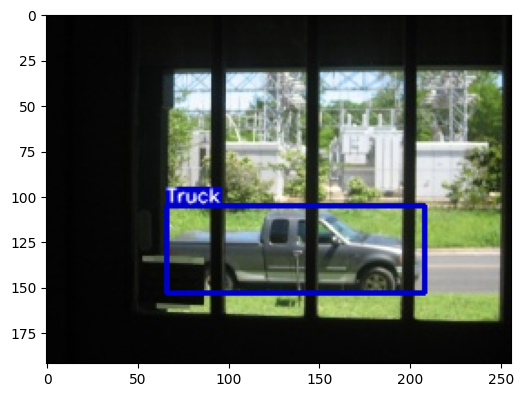

In [77]:
boxes = target['boxes'].numpy()
print(f"boxes: {boxes}")
class_ids = target['labels'].numpy()

n_obj = boxes.shape[0]
bboxes = np.zeros(shape=(n_obj, 4), dtype=np.float32)
bboxes[:, 0:2] = (boxes[:, 0:2] + boxes[:, 2:4]) / 2
bboxes[:, 2:4] = boxes[:, 2:4] - boxes[:, 0:2]
print(f"bboxes: {bboxes}")

canvas = visualize(image, bboxes, class_ids)

plt.figure(figsize=(6,6))
plt.imshow(canvas)
plt.show()

In [78]:
from torchvision import transforms

In [80]:
IMAGE_SIZE = 448

transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size=(IMAGE_SIZE, IMAGE_SIZE)),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [81]:
transformer

Compose(
    ToTensor()
    Resize(size=(448, 448), interpolation=bilinear, max_size=None, antialias=warn)
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [83]:
data_dir = "./Detection"
transformed_dataset = Detection_dataset(data_dir=data_dir, phase="train", transformer=transformer)

In [84]:
from torchvision.utils import make_grid

In [85]:
index = 5
image, target, filename = transformed_dataset[index]

/Users/jeong-wonseok/miniconda3/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


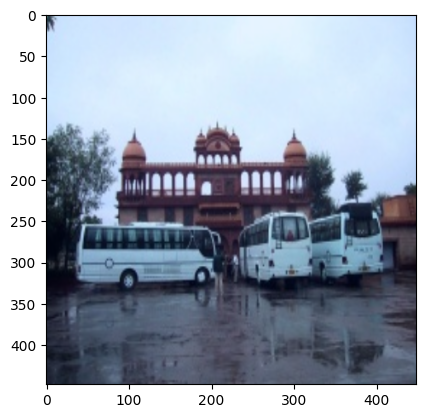

In [86]:
np_image = make_grid(image, normalize=True).cpu().permute(1,2,0).numpy()
plt.imshow(np_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


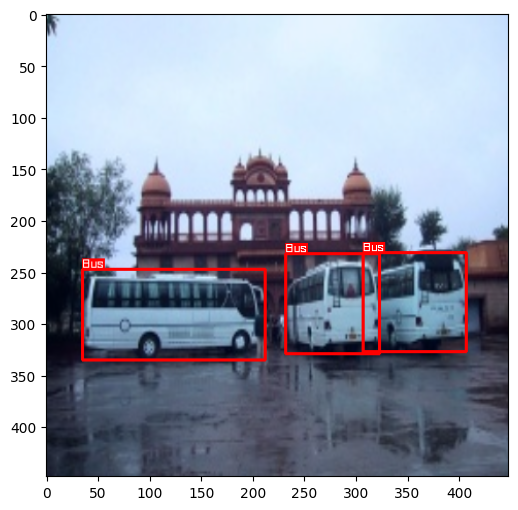

In [87]:
boxes = target['boxes'].numpy()
class_ids = target['labels'].numpy()

n_obj = boxes.shape[0]
bboxes = np.zeros(shape=(n_obj, 4), dtype=np.float32)
bboxes[:, 0:2] = (boxes[:, 0:2] + boxes[:, 2:4]) / 2
bboxes[:, 2:4] = boxes[:, 2:4] - boxes[:, 0:2]

canvas = visualize(np_image, bboxes, class_ids)

plt.figure(figsize=(6,6))
plt.imshow(canvas)
plt.show()

In [91]:
from torch.utils.data import DataLoader

In [92]:
def collate_fn(batch):
    image_list = []
    target_list = []
    filename_list = []

    for a, b, c in batch:
        image_list.append(a)
        target_list.append(b)
        filename_list.append(c)

    return image_list, target_list, filename_list

In [93]:
BATCH_SIZE = 6

trainset = Detection_dataset(data_dir=data_dir, phase="train", transformer=transformer)
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

In [94]:
for idx, batch in enumerate(trainloader):
    images = batch[0]
    targets = batch[1]
    filenames = batch[2]

    if idx == 0:
        break

/Users/jeong-wonseok/miniconda3/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/Users/jeong-wonseok/miniconda3/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in 

In [95]:
len(images)

6

In [96]:
images[0].shape

torch.Size([3, 448, 448])

In [97]:
targets

[{'boxes': tensor([[ 14.0000,   8.4000, 448.0000, 439.6000]]),
  'labels': tensor([1])},
 {'boxes': tensor([[120.6800, 135.3291, 410.2000, 393.4645]]),
  'labels': tensor([1])},
 {'boxes': tensor([[ 61.2501,  74.1104, 370.5623, 419.2908]]),
  'labels': tensor([1])},
 {'boxes': tensor([[ 87.3600,  31.6400, 352.4268, 354.7600]]),
  'labels': tensor([0])},
 {'boxes': tensor([[ 52.3363,  46.8496, 390.7787, 414.8148]]),
  'labels': tensor([1])},
 {'boxes': tensor([[ 85.9600,   0.0000, 314.7200, 311.7332]]),
  'labels': tensor([0])}]

In [98]:
filenames

['41bf05a236f732b3.jpg',
 '98e015e70520ff48.jpg',
 'a161f6e16307eb63.jpg',
 '0cbfbec0d73654c8.jpg',
 '784b225a0a87b862.jpg',
 'e352eed86be173da.jpg']

In [99]:
def build_dataloader(data_dir, batch_size=4, image_size=448):
    transformer = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize(size=(image_size, image_size)),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    dataloaders = {}
    train_dataset = Detection_dataset(data_dir=data_dir, phase="train", transformer=transformer)
    dataloaders["train"] = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

    val_dataset = Detection_dataset(data_dir=data_dir, phase="val", transformer=transformer)
    dataloaders["val"] = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)
    return dataloaders

제대로 작성했는지 확인

In [101]:
data_dir = "./Detection/"
dloaders = build_dataloader(data_dir, batch_size=4, image_size=448)

for phase in ["train", "val"]:
    for index, batch in enumerate(dloaders[phase]):
        images = batch[0]
        targets = batch[1]
        filenames = batch[2]
        print(f"{phase} - {targets}")
        print({f"{phase} - {filenames}"})
        if index == 0:
            break

train - [{'boxes': tensor([[ 22.1200, 130.0916, 427.5600, 380.6535]]), 'labels': tensor([1])}, {'boxes': tensor([[229.0400, 195.4221, 278.3200, 283.2570]]), 'labels': tensor([0])}, {'boxes': tensor([[194.0400, 201.7259, 252.0000, 272.3302]]), 'labels': tensor([0])}, {'boxes': tensor([[  0.0000, 265.7200, 214.3340, 424.2000]]), 'labels': tensor([0])}]
{"train - ['40dabc3125a0d4e0.jpg', '3ce88e6637b51112.jpg', 'b705bc5613eb4f43.jpg', '49aa7110139330cd.jpg']"}
val - [{'boxes': tensor([[261.5200, 151.9468, 431.7600, 338.9868],
        [  0.0000, 157.1732,  57.1200, 304.6400],
        [ 54.8800,   0.0000, 245.8400, 337.8668]]), 'labels': tensor([1, 1, 1])}]
{"val - ['eca6cd40621dfcc5.jpg']"}


/Users/jeong-wonseok/miniconda3/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/Users/jeong-wonseok/miniconda3/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in 